In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('C:/Users/HP/Documents/DataTrained/Intern Assignments/Questions/Malignant-Comments-Classifier-Project/Malignant Comments Classifier Project/train.csv')
train_data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [1]:
train_data = train_data.drop('id',axis = 1)
train_data.head()

NameError: name 'train_data' is not defined

In [4]:
train_data.shape

(159571, 7)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


Value counts for  malignant  is

0    144277
1     15294
Name: malignant, dtype: int64


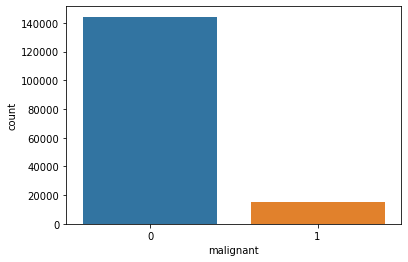

Value counts for  highly_malignant  is

0    157976
1      1595
Name: highly_malignant, dtype: int64


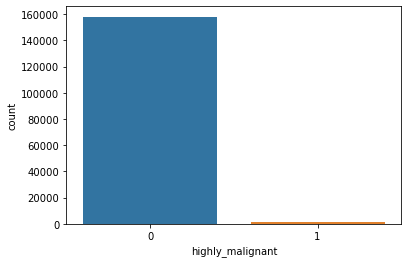

Value counts for  rude  is

0    151122
1      8449
Name: rude, dtype: int64


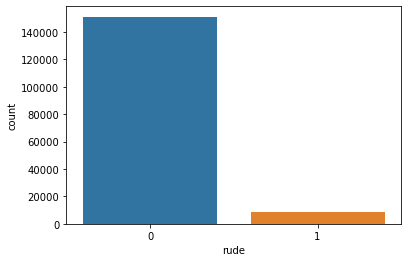

Value counts for  threat  is

0    159093
1       478
Name: threat, dtype: int64


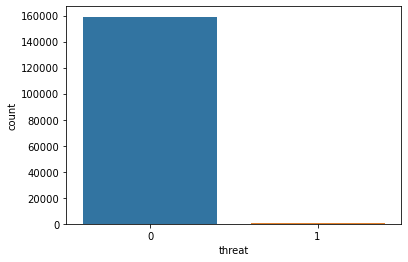

Value counts for  abuse  is

0    151694
1      7877
Name: abuse, dtype: int64


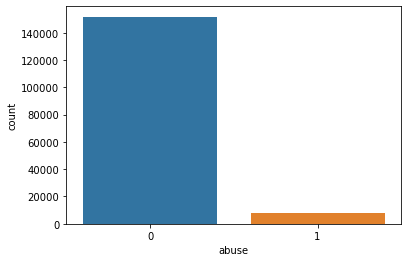

Value counts for  loathe  is

0    158166
1      1405
Name: loathe, dtype: int64


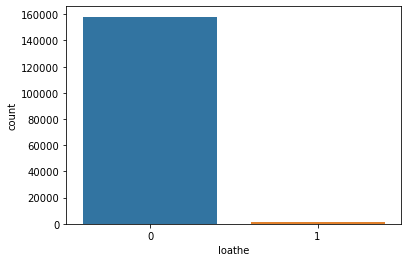

In [6]:
labels = train_data[['malignant','highly_malignant','rude','threat','abuse','loathe']]

for i in labels:
    print('Value counts for ',i,' is\n')
    print(train_data[i].value_counts())
    sns.countplot(train_data[i])
    plt.show()

### Let's combine the dependent variables to get one target variable

In [7]:
train_data['offensive'] = labels.sum(axis = 1)
y = train_data['offensive'] > 0
y = y.astype(int)
y.value_counts()

0    143346
1     16225
Name: offensive, dtype: int64

## Data Cleaning
#### 1. Checking duplicate entries and dropping them

In [8]:
train_data.duplicated().sum()

0

#### 2. Checking null values and filling them

In [9]:
train_data.isna().sum().sum()

0

## Data Preprocessing

In [10]:
import re
def decontracted(phrase):
    #specific
    phrase = re.sub(r"’","'",phrase)
    phrase = re.sub(r"”","'",phrase)
    phrase = re.sub(r"“","'",phrase)
    phrase = re.sub(r"won't","will not",phrase)
    phrase = re.sub(r"can\'t'","can not",phrase)
    
    #general
    phrase = re.sub(r"n\'t"," not",phrase)
    phrase = re.sub(r"\'re"," are",phrase)
    phrase = re.sub(r"\'s","s",phrase)
    phrase = re.sub(r"\'d"," would",phrase)
    phrase = re.sub(r"\'ll"," will",phrase)
    phrase = re.sub(r"\'t"," not",phrase)
    phrase = re.sub(r"\'ve"," have",phrase)
    phrase = re.sub(r"\'m"," am",phrase)
    return phrase

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [13]:
from tqdm import tqdm
preprocessed_comments = []
for sentence in tqdm(train_data['comment_text'].values):
    sent = decontracted(sentence)
    sent = re.sub(r'http\S+', '', sent) #remove hyperlinks
    sent = re.sub('[^A-Za-z]+',' ',sent) #remove spacial character, numbers
    sent = ' '.join(e for e in sent.split() if e not in stop_words) #removing stopwords
    sent = ' '.join(lemmatizer.lemmatize(e) for e in sent.split()) #lemmatization
    preprocessed_comments.append(sent.lower().strip()) #converting all to lower case

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:54<00:00, 2943.51it/s]


In [14]:
train_data['comment_text'] = preprocessed_comments

## Splitting data into train, cv, test

In [15]:
from sklearn.model_selection import train_test_split
x = train_data.drop(columns = ['malignant','highly_malignant','rude','threat','abuse','loathe'])
output = y

In [16]:
x.shape

(159571, 2)

In [17]:
train,test,train_output,test_output = train_test_split(x,
                                                      output,
                                                      test_size = 0.3,
                                                      stratify = output, # makes sure that no bias is created while splitting
                                                      random_state = 0)

train_modified,cv,train_output_modified,cv_output = train_test_split(train,
                                                    train_output,
                                                    test_size = 0.3,
                                                    stratify = train_output,
                                                    random_state = 0)

In [18]:
train.shape,cv.shape,test.shape

((111699, 2), (33510, 2), (47872, 2))

In [19]:
train_output.shape, cv_output.shape, test_output.shape

((111699,), (33510,), (47872,))

## Data Encoding
### 1. comment_text  - TFIDF Vectorization 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
comment_tfidf_vectorizer = TfidfVectorizer(min_df = 5)
train_comment_tfidf = comment_tfidf_vectorizer.fit_transform(train['comment_text'].values)
cv_comment_tfidf = comment_tfidf_vectorizer.transform(cv['comment_text'].values)
test_comment_tfidf = comment_tfidf_vectorizer.transform(test['comment_text'].values)

In [22]:
# saving the tfidf vectorizer
import pickle
with open("comment_tfidf_vectorizer.pickle","wb") as fp:
    pickle.dump(comment_tfidf_vectorizer,fp,protocol = pickle.HIGHEST_PROTOCOL)

In [23]:
comment_tfidf_vectorizer.get_feature_names()[:10]

['aa',
 'aaa',
 'aah',
 'aaliyah',
 'aap',
 'aardvark',
 'aaron',
 'ab',
 'aba',
 'abad']

### 2. Word2Vec

In [24]:
from gensim.models import Word2Vec

In [25]:
#using pre-trained glove model
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',errors = 'ignore', encoding = 'utf8')
    model = {}
    for line in tqdm(f):
        splitline = line.split()
        word = splitline[0]
        embedding = np.asarray([float(val) for val in splitline[1:]])
        model[word] = embedding
    print('Done ',len(model), 'words loaded')
    return model
model = loadGloveModel('C:/Users/HP/Documents/DataTrained/Data Science notes/Elective notes/glove.42B.300d.txt')

Loading Glove Model


1917494it [04:02, 7917.74it/s]

Done  1917494 words loaded


In [26]:
# saving the glove model
with open('model.pickle','wb') as fp:
    pickle.dump(model,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
glove_words = set(model.keys())

### 2.1 - comment_text - Word2Vec

In [28]:
avg_w2v_vectors_comment_train = []
avg_w2v_vectors_comment_cv = []
avg_w2v_vectors_comment_test = []

for sentence in tqdm(train['comment_text'].values):
    vector = np.zeros(300)
    cnt_words = 0 
    for word in sentence: 
        if word in glove_words:
            vector +=model[word]
            cnt_words += 1
            
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_comment_train.append(vector)
avg_w2v_vectors_comment_train = np.array(avg_w2v_vectors_comment_train)

for sentence in tqdm(cv['comment_text'].values):
    vector = np.zeros(300) 
    cnt_words = 0 
    for word in sentence:
        if word in glove_words:
            vector +=model[word]
            cnt_words += 1
            
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_comment_cv.append(vector)
avg_w2v_vectors_comment_cv = np.array(avg_w2v_vectors_comment_cv)

for sentence in tqdm(test['comment_text'].values):
    vector = np.zeros(300)
    cnt_words = 0 
    for word in sentence:
        if word in glove_words:
            vector +=model[word]
            cnt_words += 1
            
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_comment_test.append(vector)
avg_w2v_vectors_comment_test = np.array(avg_w2v_vectors_comment_test)

100%|██████████████████████████████████████████████████████████████████████████| 47872/47872 [00:17<00:00, 2688.36it/s]


## Modeling

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, f1_score, classification_report

### 1. Multinomial naive bayes with tfidf encoded features

In [30]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in alpha:
    nb_clf = MultinomialNB(alpha = i, fit_prior = True)
    nb_clf.fit(train_comment_tfidf, train_output)
    
    train_prob = nb_clf.predict_proba(train_comment_tfidf)[:,1]
    train_AUC = roc_auc_score(train_output, train_prob)
    print('for alpha = %f, train AUC = %f' % (i, train_AUC))
    
    cv_prob = nb_clf.predict_proba(cv_comment_tfidf)[:,1]
    cv_AUC = roc_auc_score(cv_output, cv_prob)
    print('for alpha = %f, cv AUC = %f' % (i, cv_AUC))
    
    train_scores = nb_clf.predict(train_comment_tfidf)
    train_f1 = f1_score(train_output, train_scores)
    print('for alpha = %f, train f1 score = %f' % (i, train_f1))
    
    cv_scores = nb_clf.predict(cv_comment_tfidf)
    cv_f1 = f1_score(cv_output, cv_scores)
    print('for alpha = %f, cv f1 score = %f' % (i, cv_f1))
    
    print('-'*50)

for alpha = 0.000010, train AUC = 0.981836
for alpha = 0.000010, cv AUC = 0.983217
for alpha = 0.000010, train f1 score = 0.784089
for alpha = 0.000010, cv f1 score = 0.784849
--------------------------------------------------
for alpha = 0.000100, train AUC = 0.981618
for alpha = 0.000100, cv AUC = 0.983020
for alpha = 0.000100, train f1 score = 0.783824
for alpha = 0.000100, cv f1 score = 0.784434
--------------------------------------------------
for alpha = 0.001000, train AUC = 0.981165
for alpha = 0.001000, cv AUC = 0.982614
for alpha = 0.001000, train f1 score = 0.783166
for alpha = 0.001000, cv f1 score = 0.783470
--------------------------------------------------
for alpha = 0.010000, train AUC = 0.980109
for alpha = 0.010000, cv AUC = 0.981660
for alpha = 0.010000, train f1 score = 0.781808
for alpha = 0.010000, cv f1 score = 0.782163
--------------------------------------------------
for alpha = 0.100000, train AUC = 0.977012
for alpha = 0.100000, cv AUC = 0.978714
for alpha

In [31]:
nb_clf_best = MultinomialNB(alpha = 0.00001, fit_prior = True)
nb_clf_best.fit(train_comment_tfidf, train_output)

test_prob = nb_clf_best.predict_proba(test_comment_tfidf)[:,1]
test_AUC = roc_auc_score(test_output, test_prob)
print("For alpha = 0.00001, test AUC = %f" % (test_AUC))

test_scores = nb_clf_best.predict(test_comment_tfidf)
test_f1 = f1_score(test_output, test_scores)
print("For alpha = 0.00001, test f1 score = %f" % (test_f1))

For alpha = 0.00001, test AUC = 0.894940
For alpha = 0.00001, test f1 score = 0.668887


In [32]:
print(classification_report(test_output,test_scores,target_names=['Label 0','Label 1']))

              precision    recall  f1-score   support

     Label 0       0.95      0.99      0.97     43004
     Label 1       0.89      0.54      0.67      4868

    accuracy                           0.95     47872
   macro avg       0.92      0.76      0.82     47872
weighted avg       0.94      0.95      0.94     47872



### 2. Bagging Classifier with Word2Vec encoded feature

In [33]:
n_estimators = [1, 10, 20, 50, 100]
for i in n_estimators:
    bg_clf = BaggingClassifier(base_estimator=None,n_estimators=i,max_samples=1.0,
                               max_features=1.0,bootstrap=True,bootstrap_features=False)
    bg_clf.fit(avg_w2v_vectors_comment_train, train_output)
    
    train_prob = bg_clf.predict_proba(avg_w2v_vectors_comment_train)[:,1]
    train_AUC = roc_auc_score(train_output, train_prob)
    print('for C = %f, train AUC = %f' % (i, train_AUC))
    
    cv_prob = bg_clf.predict_proba(avg_w2v_vectors_comment_cv)[:,1]
    cv_AUC = roc_auc_score(cv_output, cv_prob)
    print('for C = %f, cv AUC = %f' % (i, cv_AUC))
    
    train_scores = bg_clf.predict(avg_w2v_vectors_comment_train)
    train_f1 = f1_score(train_output, train_scores)
    print('for c = %f, train f1 score = %f' % (i, train_f1))
    
    cv_scores = bg_clf.predict(avg_w2v_vectors_comment_cv)
    cv_f1 = f1_score(cv_output, cv_scores)
    print('for C = %f, cv f1 score = %f' % (i, cv_f1))
    
    print('-'*50)

for C = 1.000000, train AUC = 0.850121
for C = 1.000000, cv AUC = 0.849303
for c = 1.000000, train f1 score = 0.706868
for C = 1.000000, cv f1 score = 0.704596
--------------------------------------------------
for C = 10.000000, train AUC = 0.999560
for C = 10.000000, cv AUC = 0.999542
for c = 10.000000, train f1 score = 0.932621
for C = 10.000000, cv f1 score = 0.931142
--------------------------------------------------
for C = 20.000000, train AUC = 0.999980
for C = 20.000000, cv AUC = 0.999984
for c = 20.000000, train f1 score = 0.973080
for C = 20.000000, cv f1 score = 0.977351
--------------------------------------------------
for C = 50.000000, train AUC = 0.999995
for C = 50.000000, cv AUC = 0.999995
for c = 50.000000, train f1 score = 0.996290
for C = 50.000000, cv f1 score = 0.996616
--------------------------------------------------
for C = 100.000000, train AUC = 0.999998
for C = 100.000000, cv AUC = 0.999998
for c = 100.000000, train f1 score = 0.998810
for C = 100.000000,

In [35]:
bg_clf_best = BaggingClassifier(n_estimators = 100)
bg_clf_best.fit(avg_w2v_vectors_comment_train, train_output)

test_prob = bg_clf_best.predict_proba(avg_w2v_vectors_comment_test)[:,1]
test_AUC = roc_auc_score(test_output, test_prob)
print('for n_estimator = %f, test AUC = %f' % (i, test_AUC))

test_scores = bg_clf_best.predict(avg_w2v_vectors_comment_test)
test_f1 = f1_score(test_output, test_scores)
print("For n_estimator = 100, test f1 score = %f" % (test_f1))

for n_estimator = 100.000000, test AUC = 0.762048
For n_estimator = 100, test f1 score = 0.277431


### 3. Random Forest Classifier with Word2Vec encoded feature

In [36]:
n_estimators = [1, 10, 20, 30, 50, 100]
for i in n_estimators:
    rf_clf = RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=None,
                                    min_samples_split=2,min_samples_leaf=1,)
    rf_clf.fit(avg_w2v_vectors_comment_train, train_output)
    
    train_prob = rf_clf.predict_proba(avg_w2v_vectors_comment_train)[:,1]
    train_AUC = roc_auc_score(train_output, train_prob)
    print('for n_estimator = %f, train AUC = %f' % (i, train_AUC))
    
    cv_prob = rf_clf.predict_proba(avg_w2v_vectors_comment_cv)[:,1]
    cv_AUC = roc_auc_score(cv_output, cv_prob)
    print('for n_estimator = %f, cv AUC = %f' % (i, cv_AUC))
    
    train_scores = rf_clf.predict(avg_w2v_vectors_comment_train)
    train_f1 = f1_score(train_output, train_scores)
    print('for n_estimator = %f, train f1 score = %f' % (i, train_f1))
    
    cv_scores = rf_clf.predict(avg_w2v_vectors_comment_cv)
    cv_f1 = f1_score(cv_output, cv_scores)
    print('for n_estimator = %f, cv f1 score = %f' % (i, cv_f1))
    
    print('-'*50)

for n_estimator = 1.000000, train AUC = 0.844012
for n_estimator = 1.000000, cv AUC = 0.844564
for n_estimator = 1.000000, train f1 score = 0.703048
for n_estimator = 1.000000, cv f1 score = 0.702963
--------------------------------------------------
for n_estimator = 10.000000, train AUC = 0.999672
for n_estimator = 10.000000, cv AUC = 0.999696
for n_estimator = 10.000000, train f1 score = 0.927393
for n_estimator = 10.000000, cv f1 score = 0.928459
--------------------------------------------------
for n_estimator = 20.000000, train AUC = 0.999986
for n_estimator = 20.000000, cv AUC = 0.999986
for n_estimator = 20.000000, train f1 score = 0.973993
for n_estimator = 20.000000, cv f1 score = 0.972574
--------------------------------------------------
for n_estimator = 30.000000, train AUC = 0.999995
for n_estimator = 30.000000, cv AUC = 0.999998
for n_estimator = 30.000000, train f1 score = 0.989149
for n_estimator = 30.000000, cv f1 score = 0.989177
-----------------------------------

In [37]:
rf_clf_best = RandomForestClassifier(n_estimators = 100,criterion='gini',max_depth=None,
                                    min_samples_split=2,min_samples_leaf=1,)
rf_clf_best.fit(avg_w2v_vectors_comment_train, train_output)

test_prob = rf_clf_best.predict_proba(avg_w2v_vectors_comment_test)[:,1]
test_AUC = roc_auc_score(test_output, test_prob)
print('for n_estimator = %f, test AUC = %f' % (i, test_AUC))

test_scores = rf_clf_best.predict(avg_w2v_vectors_comment_test)
test_f1 = f1_score(test_output, test_scores)
print("For n_estimator = 100, test f1 score = %f" % (test_f1))

for n_estimator = 100.000000, test AUC = 0.768923
For n_estimator = 100, test f1 score = 0.245657


In [38]:
gb_clf = GradientBoostingClassifier(n_estimators=100,criterion='friedman_mse',min_samples_split=2,min_samples_leaf=1)
gb_clf.fit(avg_w2v_vectors_comment_train, train_output)
    
train_prob = gb_clf.predict_proba(avg_w2v_vectors_comment_train)[:,1]
train_AUC = roc_auc_score(train_output, train_prob)
print('for n_estimator = 100, train AUC = ',(train_AUC))
    
cv_prob = gb_clf.predict_proba(avg_w2v_vectors_comment_cv)[:,1]
cv_AUC = roc_auc_score(cv_output, cv_prob)
print('for n_estimator = 100, cv AUC = ',(cv_AUC))
    
train_scores = gb_clf.predict(avg_w2v_vectors_comment_train)
train_f1 = f1_score(train_output, train_scores)
print('for n_estimator = 100, train f1 score =',(train_f1))
    
cv_scores = gb_clf.predict(avg_w2v_vectors_comment_cv)
cv_f1 = f1_score(cv_output, cv_scores)
print('for n_estimator = 100, cv f1 score = ',(cv_f1))

for n_estimator = 100, train AUC =  0.7980353997464622
for n_estimator = 100, cv AUC =  0.8020869615630694
for n_estimator = 100, train f1 score = 0.2829339143064633
for n_estimator = 100, cv f1 score =  0.28363283147158813


In [41]:
test_prob = gb_clf.predict_proba(avg_w2v_vectors_comment_test)[:,1]
test_AUC = roc_auc_score(test_output, test_prob)
print('for n_estimator = 100, test AUC = ',(test_AUC))

test_scores = gb_clf.predict(avg_w2v_vectors_comment_test)
test_f1 = f1_score(test_output, test_scores)
print("For n_estimator = 100, test f1 score = ",(test_f1))

for n_estimator = 100, test AUC =  0.7814790828538469
For n_estimator = 100, test f1 score =  0.25670825499914546


In [43]:
log_clf = LogisticRegression(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,intercept_scaling=1,
                             class_weight=None,random_state=None,solver='lbfgs',max_iter=100,multi_class='auto',
                             verbose=0,warm_start=False,n_jobs=None,l1_ratio=None)
log_clf.fit(avg_w2v_vectors_comment_train, train_output)
    
train_prob = log_clf.predict_proba(avg_w2v_vectors_comment_train)[:,1]
train_AUC = roc_auc_score(train_output, train_prob)
print('train AUC = ',(train_AUC))
    
cv_prob = log_clf.predict_proba(avg_w2v_vectors_comment_cv)[:,1]
cv_AUC = roc_auc_score(cv_output, cv_prob)
print('cv AUC = ',(cv_AUC))
    
train_scores = log_clf.predict(avg_w2v_vectors_comment_train)
train_f1 = f1_score(train_output, train_scores)
print('train f1 score =',(train_f1))
    
cv_scores = log_clf.predict(avg_w2v_vectors_comment_cv)
cv_f1 = f1_score(cv_output, cv_scores)
print('cv f1 score = ',(cv_f1))

train AUC =  0.7528625952373112
cv AUC =  0.7538851030793688
train f1 score = 0.18799970111335274
cv f1 score =  0.18821767348976537


In [44]:
test_prob = log_clf.predict_proba(avg_w2v_vectors_comment_test)[:,1]
test_AUC = roc_auc_score(test_output, test_prob)
print('for n_estimator = 100, test AUC = ',(test_AUC))

test_scores = log_clf.predict(avg_w2v_vectors_comment_test)
test_f1 = f1_score(test_output, test_scores)
print("For n_estimator = 100, test f1 score = ",(test_f1))

for n_estimator = 100, test AUC =  0.7548329068508044
For n_estimator = 100, test f1 score =  0.18653576437587657
